In [5]:
from src.kl_divergence import kl_divergence
from src.himmelblau import himmelblau
from src.rosenbrock import rosenbrock_3d
from src.stretch_move import stretch_move

from scipy.special import logsumexp
from scipy.stats import uniform

import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee
import dynesty

In [6]:
function = "himmelblau"
path = f"results/comparison/{function}"

file_name = f"{path}/{function}.txt"

In [7]:
# Def log_likelihood function
def log_likelihood(x):
    return -himmelblau(x)

In [9]:
# ----------------------
# MCMC
# ----------------------

# Initialize parameters
nwalkers = 40
ndim = 2
nsteps = 100000
a = 1.5

p0 = 8 * np.random.rand(nwalkers, ndim) - 4 # Initial grid

# Run costum MCMC
samples_mcmc, acceptance_count, delta_t_costum = stretch_move(log_likelihood, p0, nsteps, nwalkers, ndim, a)

# Calculate the mean acceptance rate
mean_acceptance_rate = acceptance_count / (nsteps * nwalkers)

# Calculate the autocorrelation time per parameter
autocorr_times = emcee.autocorr.integrated_time(samples_mcmc)

# Cut away 5 times the autocorellation time from samples
samples_mcmc = samples_mcmc[5 * int(np.max(autocorr_times)):]

# Reshape samples for corner plot
samples_mcmc = samples_mcmc.reshape(-1, ndim)

# Store results in file
with open(file_name, "w") as f:
    f.write(f"{function}\n")
    f.write("\n")
    f.write(f"MCMC \n")
    f.write(f"walkers: {nwalkers}\n")
    f.write(f"steps: {nsteps}\n")
    f.write(f"stretch move parameter: {a}\n")
    f.write(f"p0: {np.min(p0)},{np.max(p0)}\n")
    f.write("\n")
    f.write(f"Autocorrelation times for each dimension: {autocorr_times}\n")
    f.write(f"Mean acceptance rate: {mean_acceptance_rate}\n")
    f.write(f"Runtime for {nsteps}: {delta_t_costum}\n")


100%|██████████| 100000/100000 [00:30<00:00, 3318.83it/s]


'\nwith open(file_name, "w") as f:\n    f.write(f"{function}\n")\n    f.write("\n")\n    f.write(f"MCMC \n")\n    f.write(f"walkers: {nwalkers}\n")\n    f.write(f"steps: {nsteps}\n")\n    f.write(f"stretch move parameter: {a}\n")\n    f.write(f"p0: {np.min(p0)},{np.max(p0)}\n")\n    f.write("\n")\n    f.write(f"Autocorrelation times for each dimension: {autocorr_times}\n")\n    f.write(f"Mean acceptance rate: {mean_acceptance_rate}\n")\n    f.write(f"Runtime for\xa0{nsteps}: {delta_t_costum}\n")\n'

In [10]:
# ----------------------
# (Dynamical) Nested sampling
# ----------------------

# define the prior transform function
def prior_transform(uv):
    return 8 * uv - 4

# define the number of living points used
n_live_points = 500

# define the sampler
sampler = dynesty.DynamicNestedSampler(log_likelihood, prior_transform, ndim, n_live_points)

# run the sampler
sampler.run_nested()

# get the results
results = sampler.results
results.summary()

samples_nested = results.samples

# cut away about 10% of the samples
samples_nested = samples_nested[1000:]

# append results
with open(file_name, "a") as f:
    f.write("\n")
    f.write(f"Nested sampling\n")
    f.write(f"livepoints: {n_live_points}\n")
    f.write(f"niter: {results.niter}\n")
    f.write(f"Log-evidence: {results.logz[-1]} +/- {results.logzerr[-1]}\n")

14516it [00:04, 3083.52it/s, batch: 8 | bound: 4 | nc: 1 | ncall: 57415 | eff(%): 20.735 | loglstar: -5.601 < -0.000 < -0.434 | logz: -5.251 +/-  0.053 | stop:  0.890]            

Summary
niter: 14516
ncall: 39594
eff(%): 20.735
logz: -5.224 +/-  0.050


'\nwith open(file_name, "a") as f:\n    f.write("\n")\n    f.write(f"Nested sampling\n")\n    f.write(f"livepoints: {n_live_points}\n")\n    f.write(f"niter: {results.niter}\n")\n    f.write(f"Log-evidence: {results.logz[-1]} +/- {results.logzerr[-1]}\n")\n'

In [11]:
# Calculate KL divergence
kl = kl_divergence(samples_nested, samples_mcmc, bins=50)

# write to file
with open(file_name, "a") as f:
    f.write("\n")
    f.write(f"KL divergence: {kl}\n")
    f.close

'\nwith open(file_name, "a") as f:\n    f.write("\n")\n    f.write(f"KL divergence: {kl}\n")\n    f.close\n'

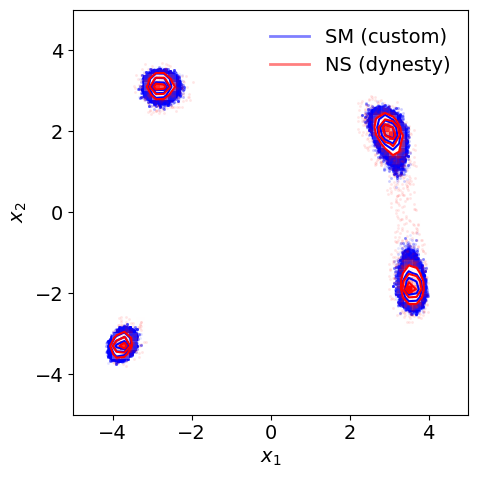

In [11]:
# ----------------------
# Plot 2D Histogram
# ----------------------

# Define labels for the dimensions
labels = ["$x_1$", "$x_2$"]

# Set the font size
plt.rcParams.update({'font.size': 14})

# Create a new figure for the 2D plot
fig, ax = plt.subplots(figsize=(5, 5))

# Define the range for x_1 and x_2
plot_range = [[-5, 5], [-5, 5]]

# Generate the 2D corner plot for MCMC samples
corner.hist2d(samples_mcmc[:, 0], samples_mcmc[:, 1], bins=50, ax=ax, plot_contours=True, color="blue", alpha=0.5, range=plot_range)

# Generate the 2D corner plot for nested sampling samples
corner.hist2d(samples_nested[:, 0], samples_nested[:, 1], bins=50, ax=ax, plot_contours=True, color="red", alpha=0.8, range=plot_range)

# Set labels for the axes
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# Create legend handles
handles = [
    plt.Line2D([0], [0], color="blue", lw=2, label="SM (custom)", alpha=0.5),
    plt.Line2D([0], [0], color="red", lw=2, label="NS (dynesty)", alpha=0.5)
]
ax.legend(handles=handles, loc="upper right", frameon=False, fontsize=14)

# Adjust layout and save the figure
fig.tight_layout()
fig.savefig(f"{path}/{function}_corner_2D_comparison.pdf")